In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
neg_test = pd.read_csv('neg_testdate.csv',index_col=0)
pos_test = pd.read_csv('pos_testdate.csv',index_col=0)
lc_u = np.load('uid_per_shb_fatigue.npy')

In [3]:
def get_epoch(user_ids):
    
   
    ft = tuple(user_ids)    
    df = query_ch_df(
            #"""DESCRIBE TABLE rocs.test_table"""
        #"""SELECT * FROM rocs.vital_data_epoch WHERE vital_data_epoch.customer IN {formatter}"""
        """SELECT * FROM rocs.vital_data_epoch WHERE vital_data_epoch.customer IN {}""".format(ft) 
        #"""SELECT * FROM rocs.vital_data_epoch LIMIT 5000"""
        )
    return df

In [4]:
def get_demo(user_ids):
    
    if isinstance(user_ids, int) or isinstance(user_ids, np.int64):
        formatter = f'({user_ids})'
    elif len(user_ids) == 1:
        formatter = f'({user_ids[0]})'
    else:
        formatter = tuple(user_ids) 
    
    
    
    query = f"""
    SELECT 
        user_id, salutation, birth_date, weight, height, creation_timestamp
    FROM 
        rocs.datenspende.users
    WHERE 
        users.user_id IN {formatter} 
   
    """ 

    users = query_pg_df(query)
    users.creation_timestamp = pd.to_datetime(users['creation_timestamp'],unit='ms') 
    users.creation_timestamp = users.creation_timestamp.dt.date
    users['age'] = np.floor((2023 + 1 / 12) - users['birth_date'] + 2.5)

    
    
    return users

In [5]:
def get_info(user_ids):
    
    # Make sure that the IN-condition for the SQL query either takes the form '(userid)' in the case
    # of a single requested user id or '(userid1, userid2, ..., useridN)' in the case of multiple
    # requested user ids
    if isinstance(user_ids, int) or isinstance(user_ids, np.int64):
        formatter = f'({user_ids})'
    elif len(user_ids) == 1:
        formatter = f'({user_ids[0]})'
    else:
        formatter = tuple(user_ids)
    
    
    
    qu = f"""
    select
        
        a.user_id,
        a.created_at,
        a.question,
        a.element
        
    from 
        rocs.datenspende.answers a
    where 
        a.user_id IN {formatter}
    AND
        a.question = 127
        

    """

    users = query_pg_df(qu)
    users.created_at = pd.to_datetime(users['created_at'],unit='ms')
    users.created_at = users.created_at.dt.date
    
    
    return users

In [ ]:
def get_vitals(user_ids):
    
    # Make sure that the IN-condition for the SQL query either takes the form '(userid)' in the case
    # of a single requested user id or '(userid1, userid2, ..., useridN)' in the case of multiple
    # requested user ids
    if isinstance(user_ids, int) or isinstance(user_ids, np.int64):
        formatter = f'({user_ids})'
    elif len(user_ids) == 1:
        formatter = f'({user_ids[0]})'
    else:
        formatter = tuple(user_ids)
    
    
    
    query = f"""
    SELECT 
        user_id AS userid, date, type AS vitalid, value, source AS deviceid
    FROM 
        datenspende.vitaldata
    WHERE 
        vitaldata.user_id IN {formatter}
    AND
        vitaldata.type IN (9, 65, 43)
    """

    vitals = query_pg_df(query)
    vitals.date = pd.to_datetime(vitals.date)    

    
    
    return vitals

In [ ]:
get_demo([us_id_lc])

In [ ]:
get_info([us_id_lc])

In [6]:
value_types = pd.read_csv('epoch_value_types.csv')
value_types = value_types.rename(columns={"id": "type"})

In [7]:
def modify_df(user_df):
    user_df.startTimestamp = user_df.startTimestamp//1000
    user_df.endTimestamp = user_df.endTimestamp//1000
    user_df.startTimestamp = user_df.startTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
    user_df.endTimestamp = user_df.endTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
    user_df['date'] = user_df.startTimestamp.apply(lambda x: x.date())
    
    user_df = user_df.merge(value_types, how='left', on = 'type')
    #user_df['entries'] = 1
    
    user_df['tdelta'] = user_df['endTimestamp'] - user_df['startTimestamp']
    user_df['tdelta_min'] = user_df['tdelta'].apply(lambda x: x.total_seconds()//60)
    user_df['tdelta_sec'] = user_df['tdelta'].apply(lambda x: x.total_seconds())
    user_df['date'] = pd.to_datetime(user_df['date'])
    
    bins = list(range(0,97))
    user_df['Time Bin 1'] = pd.cut((user_df.startTimestamp.dt.minute//15) + (user_df.startTimestamp.dt.hour * 4), bins,right=False)
    user_df['Time Bin 2'] = pd.cut((user_df.endTimestamp.dt.minute//15) + (user_df.endTimestamp.dt.hour * 4), bins,right=False)
    user_df['Interval'] = user_df.apply(lambda x: pd.Interval(x['startTimestamp'],x['endTimestamp'],closed='right'), axis=1)    

    
    return user_df

In [8]:
def combine_overlaps(pdt, vt):
    # per day find measurements which were recorded in overlapping time intervals 
    # combine them by summing up steps and adjusting the interval
    # add new entry to df and drop old entries
    pdt = pdt.copy()
    pdt.index = np.arange(1, len(pdt) + 1)
    drop_i = []
    cps = []    
    for iv in pdt['Interval']:
        i = pdt[pdt['Interval'] == iv].index
        ov = pdt[pdt['Time Bin 1'] == pdt['Time Bin 1'].loc[i].values[0]].copy()
        ov['ov'] = ov['Interval'].apply(lambda x: x.overlaps(iv))
        ov = ov[ov['ov']==True]
        if len(ov) > 1:
            i_min_s = ov[ov['startTimestamp'] == min(ov['startTimestamp'])].index[0]
            i_max_e = ov[ov['endTimestamp'] == max(ov['endTimestamp'])].index[0]            
            ts = (ov['endTimestamp'].loc[i_min_s] - ov['startTimestamp'].loc[i_min_s]).total_seconds()
            
            if vt == 'doubleValue':
                td = (ov['startTimestamp'].loc[i_max_e]- ov['startTimestamp'].loc[i_min_s]).total_seconds()
                f1 = td/ts
                comb_val = (f1 * ov[vt].loc[i_min_s]) + ov[vt].loc[i_max_e]
                comb_val = comb_val
            elif vt == 'longValue':
                te = (ov['endTimestamp'].loc[i_max_e]- ov['startTimestamp'].loc[i_max_e]).total_seconds()
                tt = (ov['endTimestamp'].loc[i_max_e]- ov['startTimestamp'].loc[i_min_s]).total_seconds()
                comb_val = np.average([ov[vt].loc[i_min_s],  ov[vt].loc[i_max_e]], weights=[ts/tt, te/tt])
            elif vt == 'booleanValue':
                
                comb_val = ov[vt].loc[i_min_s]
                
            cp = ov.iloc[0].copy()
            cp[vt] = comb_val
            cp['ov'] = False
            cp['startTimestamp'] = pd.Timestamp(ov['startTimestamp'].loc[i_min_s])
            cp['endTimestamp'] = pd.Timestamp(ov['endTimestamp'].loc[i_max_e])
            cp['Interval'] = pd.Interval(cp['startTimestamp'],cp['endTimestamp'],closed='neither')
            cp['Time Bin 1'] = ov['Time Bin 1'].loc[i_min_s]
            cp['Time Bin 2'] = ov['Time Bin 2'].loc[i_max_e]
            #pdt = pdt.drop(ov.index,axis=0)
            drop_i.append(ov.index)
            cps.append(cp)
            
            #pdt.loc[len(pdt)+1] = cp
            #print(i)
           
        pdt['ov'] = False
    drop_i = list(set(sum([list(a) for a in drop_i], [])))
    pdt = pdt.drop(drop_i,axis=0)
    for c in cps:
        pdt.loc[len(pdt)+1] = c
    
    return pdt

In [9]:
# for measurements which fall into multiple time bins, calculate fraction of measured steps for each one of the time bins
# for every unique time bin create a new row and drop the old one
def multiple_bins(i_multiple_bins, dn, time_bins, bin_s, bin_e,vt):
    cps = []
    for mbi in i_multiple_bins:
        mult_bin = dn.loc[mbi].copy()
        dn = dn.drop(mbi,axis=0)
        # get index of first time bin and last time bin of the multiple time bins to get all bins in between
        first_bini = [t for t in range(len(time_bins)) if time_bins[t] == mult_bin['Time Bin 1']][0]
        last_bini = [t for t in range(len(time_bins)) if time_bins[t] == mult_bin['Time Bin 2']][0]

        t = mult_bin['endTimestamp']-mult_bin['startTimestamp'] # duration of the measurement
        for b in range(first_bini, last_bini+1):
            cp = mult_bin.copy()

            if b == first_bini:
                dur = datetime.datetime.combine(datetime.date.min, datetime.datetime.strptime(bin_e[b], '%H:%M:%S').time()) - datetime.datetime.combine(datetime.date.min,  mult_bin['startTimestamp'].time())
                if vt == 'doubleValue':
                    val = (dur/t) * mult_bin[vt]
                elif (vt == 'longValue') or (vt == 'booleanValue'):
                    val = mult_bin[vt]
                cp['startTimestamp'] = mult_bin['startTimestamp']
                cp['endTimestamp'] = cp['startTimestamp'] + dur

            elif b == last_bini:
                # in order to account for that second (when there are only two time bins the measurement falls into) time bin starts at the same time that first one ends, add one second to duration w factor a
                if len(range(first_bini, last_bini+1)) > 2: 
                    a = datetime.timedelta(seconds=0) 
                else:
                    a = datetime.timedelta(seconds=1)
                dur = datetime.datetime.combine(datetime.date.min, mult_bin['endTimestamp'].time() ) - datetime.datetime.combine(datetime.date.min,  datetime.datetime.strptime(bin_s[b], '%H:%M:%S').time())
                
                if vt == 'doubleValue':
                    val = ((dur+a)/t) * mult_bin[vt]
                elif (vt == 'longValue') or (vt == 'booleanValue'):
                    val = mult_bin[vt]
                cp['startTimestamp'] = mult_bin['endTimestamp'] - dur
                cp['endTimestamp'] = mult_bin['endTimestamp']
            else:
                # in order to account for that the n'th (when there are more than two time bins the measurement falls into) time bin starts at the same time that n-1 one ends, add one second to duration w factor a
                if len(range(first_bini, last_bini+1)) < 2:
                    a = datetime.timedelta(seconds=0)
                else:
                    a = datetime.timedelta(seconds=1)
                bin_st = datetime.datetime.strptime(bin_s[b], '%H:%M:%S').time()
                bin_et = datetime.datetime.strptime(bin_e[b], '%H:%M:%S').time() 
                dur = (datetime.datetime.combine(datetime.date.min, bin_et) - datetime.datetime.combine(datetime.date.min, bin_st ))#+1
                if vt == 'doubleValue':
                    al = ((dur+a)/t) * mult_bin[vt]
                elif (vt == 'longValue') or (vt == 'booleanValue'):
                    val = mult_bin[vt]
                cp['startTimestamp'] = mult_bin['date'] + datetime.timedelta(hours=bin_st.hour, minutes=bin_st.minute, seconds=bin_st.second)
                cp['endTimestamp'] = mult_bin['date'] + datetime.timedelta(hours=bin_et.hour, minutes=bin_et.minute, seconds=bin_et.second)
            cp[vt] = val
            cp['Time Bin 1'] = time_bins[b]
            cp['Time Bin 2'] = time_bins[b]
            cp['Interval'] = pd.Interval(cp['startTimestamp'],cp['endTimestamp'],closed='neither')
            cps.append(cp)

    # append new rows to dataframe
    dn.index = np.arange(1, len(dn) + 1)
    for c in cps:
        dn.loc[len(dn)+1] = c
    return dn

In [61]:
#us_id = 357322
us_id = 183492


In [62]:
udf = get_epoch([us_id])
udf = udf.rename(columns={"customer": "user_id"})
udf = modify_df(udf)

In [12]:
# get starting and end times of hourly bins
bin_s = []
bin_e = []
for h in range(24):
    for m in range(4):
    
        time_string_s = '%02d:%02d:%02d' % (h,m * 15,0)
        time_string_e = '%02d:%02d:%02d' % (h,(m * 15) + 14,59)
        bin_s.append(time_string_s)
        bin_e.append(time_string_e)
time_bins = sorted(udf['Time Bin 1'].unique())

### steps

In [13]:
vt_i = udf[udf['type'] == 1000]['valueType'].iloc[0]
if vt_i == 0:
    vt = 'doubleValue'
elif vt_i == 1:
    vt = 'longValue'
elif vt_i == 2:
    vt = 'booleanValue'
    
u_val_df = udf[udf['type'] == 1000][[vt, 'date', 'code', 'Time Bin 1', 'Time Bin 2', 'Interval','startTimestamp', 'endTimestamp']]
val_code = u_val_df['code'].iloc[0]

In [14]:
pdt_df = []
for date in u_val_df['date'].unique():
    pdt_df.append(combine_overlaps(u_val_df[u_val_df['date']==date],vt))   

In [15]:
dn = pd.concat(pdt_df, axis=0)

In [16]:
# re-index
dn.index = np.arange(1, len(dn) + 1)

In [17]:
i_multiple_bins = dn[dn['Time Bin 1']!= dn['Time Bin 2']].index
dn = multiple_bins(i_multiple_bins, dn, time_bins, bin_s, bin_e,vt) 

In [18]:
dn['measurement time [s]'] = dn['Interval'].apply(lambda x: x.length.total_seconds())

In [19]:
dn['steps per s'] = dn[vt] / dn['measurement time [s]']

In [20]:
dn = dn[dn['measurement time [s]'] != 0]

In [21]:
df_agg = dn[['code','date', 'Time Bin 1']].drop_duplicates(
  subset = ['date', 'Time Bin 1'],
  keep = 'last').reset_index(drop = True)

In [22]:
# per day, aggregate meausrements for every time bin by taking mean value of steps per second 
df_agg['steps_per_s'] = dn.groupby(['date', 'Time Bin 1']).mean(numeric_only=True)['steps per s'].values
df_agg['steps'] = dn.groupby(['date', 'Time Bin 1']).sum(numeric_only=True)[vt].values

In [23]:
dates = []
tb = []

for d in df_agg['date'].unique():
    for t in time_bins:
        dates.append(d)
        tb.append(t)
       
        

In [24]:
df = pd.merge(pd.DataFrame(data={'date':dates ,'Time Bin 1':tb}), df_agg[['date', 'Time Bin 1', 'steps_per_s', 'steps']], how='outer', on=['date', 'Time Bin 1'])

### heart rate

In [25]:
vt_i = udf[udf['type'] == 3000]['valueType'].iloc[0]
if vt_i == 0:
    vt = 'doubleValue'
elif vt_i == 1:
    vt = 'longValue'
elif vt_i == 2:
    vt = 'booleanValue'
    
u_val_df = udf[udf['type'] == 3000][[vt, 'date', 'code','Time Bin 1', 'Time Bin 2', 'Interval','startTimestamp', 'endTimestamp']]
val_code = u_val_df['code'].iloc[0]

In [26]:
u_val_df['s'] = u_val_df['Interval'].apply(lambda x: x.length.total_seconds())

In [27]:
pdt_df = []
for date in u_val_df['date'].unique():
    
    pdt_df.append(combine_overlaps(u_val_df[u_val_df['date']==date],vt))   
    

In [28]:
dn = pd.concat(pdt_df, axis=0)

In [29]:
# re-index
dn.index = np.arange(1, len(dn) + 1)

In [30]:
i_multiple_bins = dn[dn['Time Bin 1']!= dn['Time Bin 2']].index

In [31]:
i_multiple_bins = dn[(dn['Time Bin 1']!= dn['Time Bin 2'])&(dn['s'] != 60)].index
dn = multiple_bins(i_multiple_bins, dn, time_bins, bin_s, bin_e,vt) 

In [32]:
df_agg = dn[['date', 'Time Bin 1']].drop_duplicates(
  subset = ['date', 'Time Bin 1'],
  keep = 'last').reset_index(drop = True)

In [33]:
# per day, aggregate meausrements for every time bin by taking mean value of steps per second 
df_agg['hr'] = dn.groupby(['date', 'Time Bin 1']).mean(numeric_only=True)[vt].values

In [34]:
#merge w df above
df_comb = pd.merge(df, df_agg[['date', 'Time Bin 1', 'hr']], how='outer', on=['date', 'Time Bin 1'])

In [35]:
#df_comb.to_csv('df_u'+str(357322)+'.csv')

## sleep

In [36]:
vt_i = udf[udf['type'] == 2000]['valueType'].iloc[0]
if vt_i == 0:
    vt = 'doubleValue'
elif vt_i == 1:
    vt = 'longValue'
elif vt_i == 2:
    vt = 'booleanValue'
    
u_val_df = udf[udf['type'] == 2000][[vt,'date', 'code','Time Bin 1', 'Time Bin 2', 'Interval','startTimestamp', 'endTimestamp']]
val_code = u_val_df['code'].iloc[0]

In [37]:
pdt_df = []
for date in u_val_df['date'].unique():
    
    pdt_df.append(combine_overlaps(u_val_df[u_val_df['date']==date],vt))   
    

In [38]:
dn = pd.concat(pdt_df, axis=0)

In [39]:
# re-index
dn.index = np.arange(1, len(dn) + 1)

In [40]:
i_multiple_bins = dn[dn['Time Bin 1']!= dn['Time Bin 2']].index

In [41]:
i_multiple_bins = dn[(dn['Time Bin 1']!= dn['Time Bin 2'])].index
dn = multiple_bins(i_multiple_bins, dn, time_bins, bin_s, bin_e,vt) 

In [42]:
df_agg = dn[['date', 'Time Bin 1']].drop_duplicates(
  subset = ['date', 'Time Bin 1'],
  keep = 'last').reset_index(drop = True)

In [43]:
# per day, aggregate meausrements for every time bin by taking mean value of steps per second 
df_agg['sleep'] = dn.groupby(['date', 'Time Bin 1']).mean()[vt].values

In [44]:
#merge w df above
df_comb = pd.merge(df_comb, df_agg[['date', 'Time Bin 1', 'sleep']], how='outer', on=['date', 'Time Bin 1'])

In [45]:
#df_comb.to_csv('df_u'+str(357322)+'.csv')

## rhr

In [46]:
vt_i = udf[udf['type'] == 3001]['valueType'].iloc[0]
if vt_i == 0:
    vt = 'doubleValue'
elif vt_i == 1:
    vt = 'longValue'
elif vt_i == 2:
    vt = 'booleanValue'
    
u_val_df = udf[udf['type'] == 3001][[vt, 'date', 'code', 'Time Bin 1', 'Time Bin 2', 'Interval','startTimestamp', 'endTimestamp']]
val_code = u_val_df['code'].iloc[0]

In [47]:
u_val_df['s'] = u_val_df['Interval'].apply(lambda x: x.length.total_seconds())

In [48]:
pdt_df = []
for date in u_val_df['date'].unique():
    
    pdt_df.append(combine_overlaps(u_val_df[u_val_df['date']==date],vt))   
    

In [49]:
dn = pd.concat(pdt_df, axis=0)

In [50]:
# re-index
dn.index = np.arange(1, len(dn) + 1)

In [51]:
i_multiple_bins = dn[dn['Time Bin 1']!= dn['Time Bin 2']].index

In [52]:
i_multiple_bins = dn[(dn['Time Bin 1']!= dn['Time Bin 2'])&(dn['s'] != 60)].index
dn = multiple_bins(i_multiple_bins, dn, time_bins, bin_s, bin_e,vt) 

In [53]:
df_agg = dn[['date', 'Time Bin 1']].drop_duplicates(
  subset = ['date', 'Time Bin 1'],
  keep = 'last').reset_index(drop = True)

In [54]:
# per day, aggregate meausrements for every time bin by taking mean value of steps per second 
df_agg['rhr'] = dn.groupby(['date', 'Time Bin 1']).mean(numeric_only=True)[vt].values

In [55]:
#df = pd.read_csv('df_u357322.csv',index_col=0)

In [56]:
#df['date'] = pd.to_datetime(df['date'])

In [57]:
#merge w df above
df_comb = pd.merge(df_comb, df_agg[['date', 'Time Bin 1', 'rhr']], how='outer', on=['date', 'Time Bin 1'])

In [58]:
df_comb.to_csv('df_u'+str(us_id)+'.csv')

# get test date

In [65]:
us_id_lc= 357322
us_id_neg = 183492
df_comb_lc = pd.read_csv('df_u'+str(us_id_lc)+'.csv',index_col=0)
df_comb_neg = pd.read_csv('df_u'+str(us_id_neg)+'.csv',index_col=0)

In [66]:
df_comb_lc['day_of_week'] = pd.to_datetime(df_comb_lc['date']).dt.dayofweek
df_comb_neg['day_of_week'] = pd.to_datetime(df_comb_neg['date']).dt.dayofweek

In [67]:
df_comb_lc['weekend'] = df_comb_lc['day_of_week'].apply(lambda x: True if x >= 4 else False)
df_comb_neg['weekend'] = df_comb_neg['day_of_week'].apply(lambda x: True if x >= 4 else False)

In [68]:
df_comb_lc['dt'] = pd.to_datetime(pos_test['dt'][pos_test['user_id'].isin([us_id_lc])].iloc[0])
td = pd.to_datetime(df_comb_lc['date']) - df_comb_lc['dt'] 
df_comb_lc['week_totest'] = td.apply(lambda x: -(x.days// - 7))

df_comb_neg['dt'] = pd.to_datetime(neg_test['dt'][neg_test['user_id'].isin([us_id_neg])].iloc[0])
td = pd.to_datetime(df_comb_neg['date']) - df_comb_neg['dt'] 
df_comb_neg['week_totest'] = td.apply(lambda x: -(x.days// - 7))

In [69]:
df_comb_lc['time'] = df_comb_lc['Time Bin 1'].map(dict(zip(list(df_comb_lc['Time Bin 1'].unique()),list(range(97)))))
df_comb_neg['time'] = df_comb_neg['Time Bin 1'].map(dict(zip(list(df_comb_neg['Time Bin 1'].unique()),list(range(97)))))

In [70]:
def phases(week):
    if week < 0:
        ph = 0
    elif (week >= 0 and week <= 4):
        ph = 1
    elif (week >= 5 and week <= 12):
        ph = 2
    elif week > 12:
        ph = 3
    return ph

In [71]:
df_comb_lc['phase'] = df_comb_lc['week_totest'].apply(lambda x: phases(x))
df_comb_neg['phase'] = df_comb_neg['week_totest'].apply(lambda x: phases(x))

In [108]:
df_comb_lc[df_comb_lc['date'] == df_comb_lc['date'].iloc[0]]['steps'].sum()

6635.410060149584

In [109]:
df_comb_lc['date'].iloc[0]

'2020-09-22'

In [73]:
# female 45 years old
age = 45
MAX_HR = 208 - (0.7 * age)

In [74]:
df_comb_lc['d to max hr [%]'] = (df_comb_lc['hr'])/ MAX_HR * 100
#df_comb_lc['rd rhr [%]'] = (df_comb_lc['rhr'])/ MAX_HR * 100

df_comb_neg['d to max hr [%]'] = (df_comb_neg['hr']/ MAX_HR) * 100
#df_comb_neg['rd rhr [%]'] = (df_comb_neg['rhr'])/ MAX_HR * 100

In [75]:
dfs = [df_comb_neg, df_comb_lc]

In [107]:
# plt.figure(figsize=(25,10))
# df = dfs[1]
# w = -10
# plt.plot(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['steps'].values)
# plt.xticks(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['Time Bin 1'],rotation
#            =90);
# w = 0
# plt.plot(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['steps'].values)
# plt.xticks(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['Time Bin 1'],rotation
#            =90);

# w = 10
# plt.plot(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['steps'].values)
# plt.xticks(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['Time Bin 1'],rotation
#            =90);

# plt.legend(['-10 w', '0 w', '10 w']);

In [106]:
# plt.figure(figsize=(25,10))
# df = dfs[1]
# w = -10
# plt.plot(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['hr'].values)
# plt.xticks(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['Time Bin 1'],rotation
#            =90);
# w = 0
# plt.plot(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['hr'].values)
# plt.xticks(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['Time Bin 1'],rotation
#            =90);

# w = 10
# plt.plot(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['hr'].values)
# plt.xticks(range(len(df[df['week_totest']==w])),df[df['week_totest']==w]['Time Bin 1'],rotation
#            =90);

# plt.legend(['-10 w', '0 w', '10 w']);

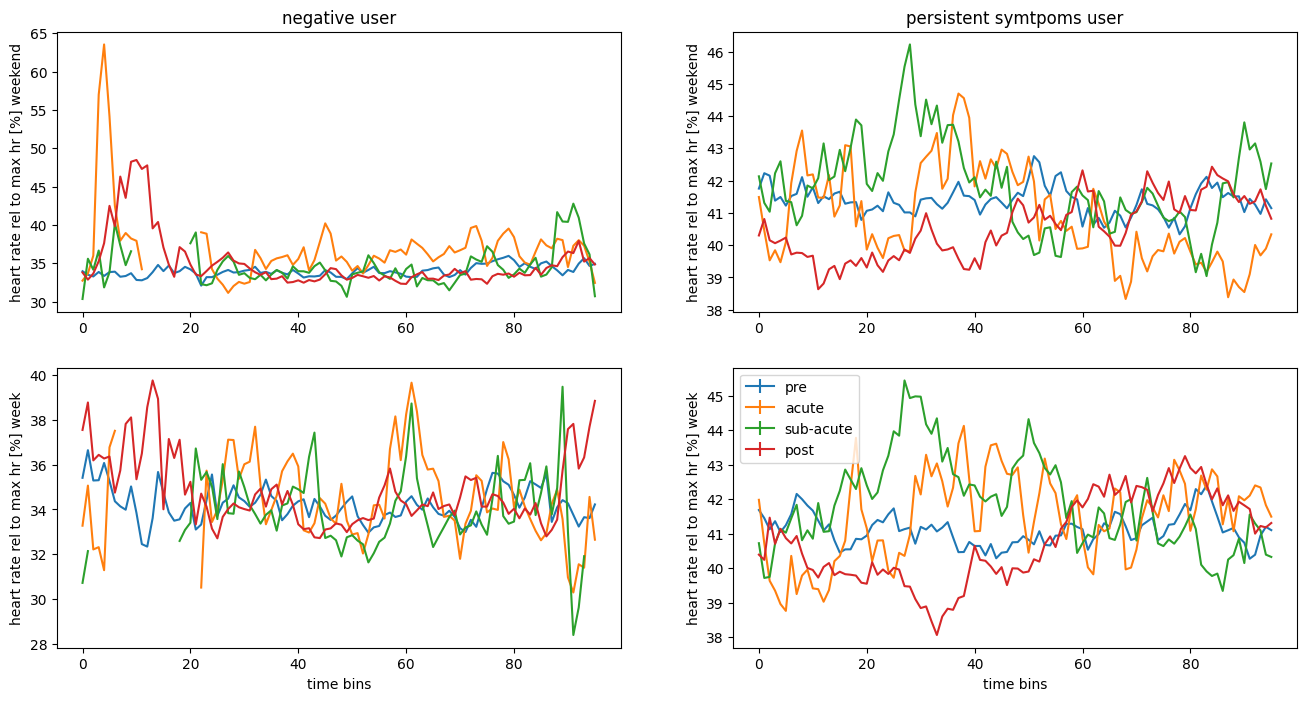

In [84]:
fig, ax = plt.subplots(2,2, figsize=(16,8))
u = ['negative user', 'persistent symtpoms user']
for i in range(2):
    for ph in [0,1,2,3]:
        df = dfs[i]
        dfph = df[df['phase'] == ph]
        dfph_we = dfph[dfph['weekend'] == True]
        dfph_wd = dfph[dfph['weekend'] == False]
        ax[0,i].errorbar(dfph_we.groupby('time').mean().index, dfph_we.groupby('time').mean()['d to max hr [%]'], yerr=0)
        ax[1,i].errorbar(dfph_wd.groupby('time').mean().index, dfph_wd.groupby('time').mean()['d to max hr [%]'], yerr=0)
        ax[0,i].set_ylabel('heart rate rel to max hr [%] weekend')
        ax[1,i].set_ylabel('heart rate rel to max hr [%] week')
        ax[1,i].set_xlabel('time bins')
        ax[0,i].set_title(u[i])
plt.legend(['pre', 'acute', 'sub-acute', 'post']);

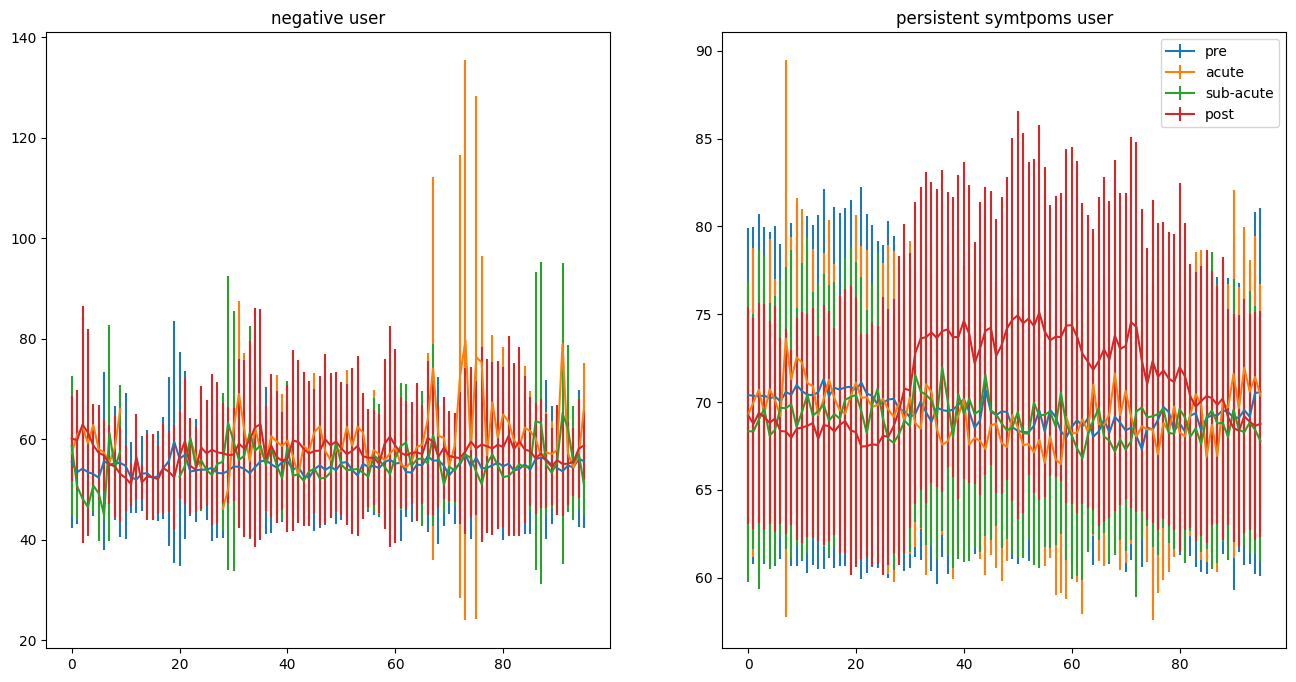

In [102]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
u = ['negative user', 'persistent symtpoms user']
for i in range(2):
    for ph in [0,1,2,3]:
        df = dfs[i]
        dfph = df[df['phase'] == ph]
        ax[i].errorbar(dfph.groupby('time').mean().index, dfph.groupby('time').mean()['rhr'], yerr=dfph.groupby('time').std()['rhr'])
        ax[i].set_title(u[i])
plt.legend(['pre', 'acute', 'sub-acute', 'post']);

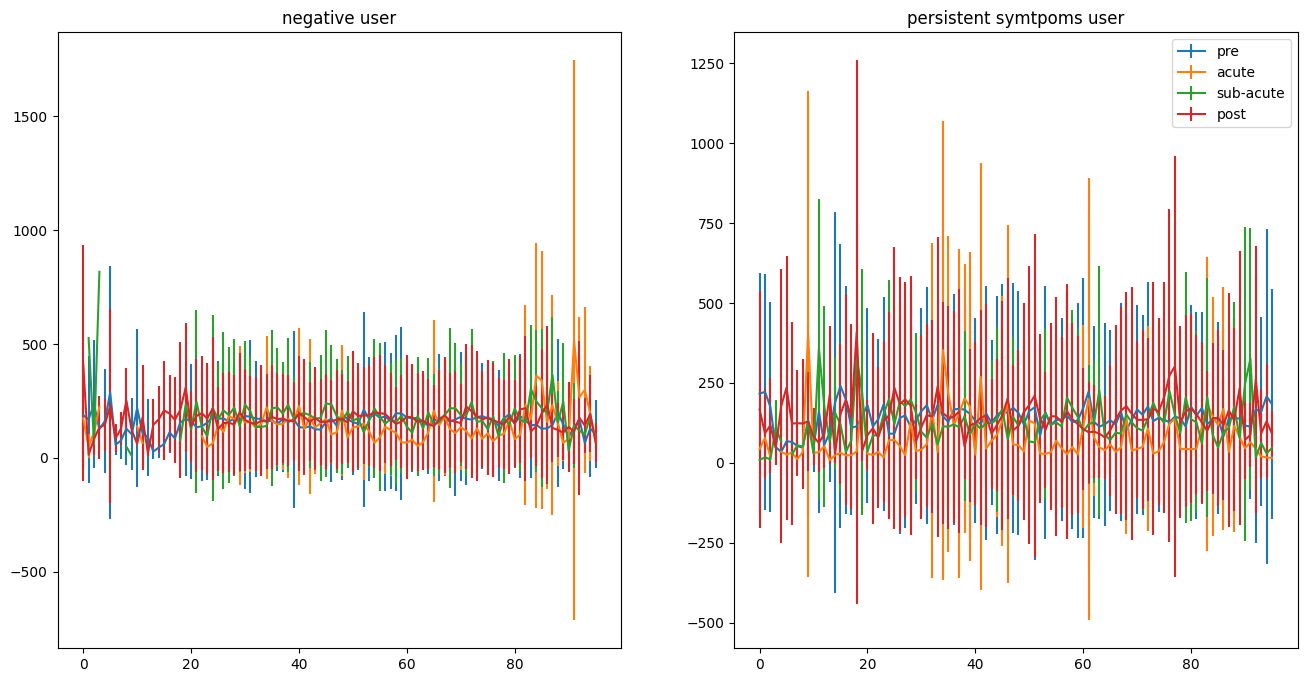

In [105]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
u = ['negative user', 'persistent symtpoms user']
for i in range(2):
    for ph in [0,1,2,3]:
        df = dfs[i]
        dfph = df[df['phase'] == ph]
        ax[i].errorbar(dfph.groupby('time').mean().index, dfph.groupby('time').mean()['steps'], yerr=dfph.groupby('time').std()['steps'])
        ax[i].set_title(u[i])
plt.legend(['pre', 'acute', 'sub-acute', 'post']);

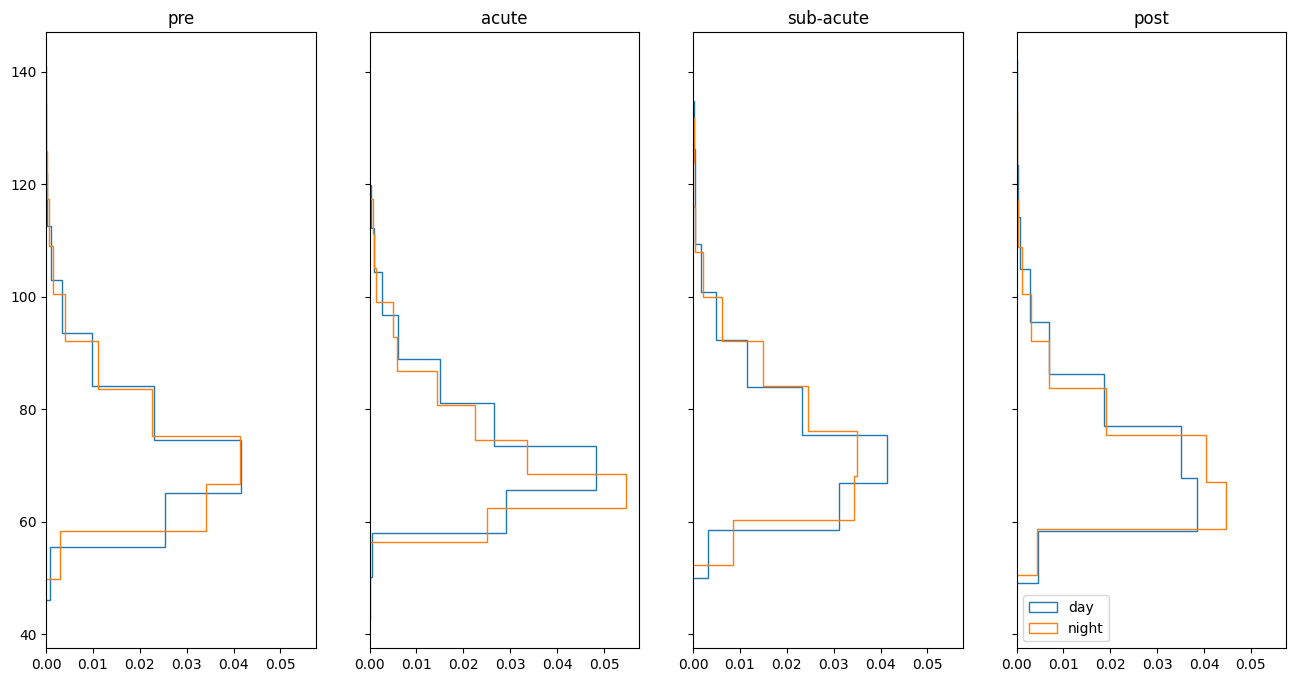

In [116]:
fig, ax = plt.subplots(1,4, figsize=(16,8),sharey=True,sharex=True)
phases = ['pre', 'acute', 'sub-acute', 'post']
for ph in [0,1,2,3]:
    df = dfs[1]
    dfph = df[df['phase'] == ph]
    ax[ph].hist(dfph[dfph['sleep'] != 1]['hr'], density = True, histtype='step',orientation='horizontal')
    ax[ph].hist(dfph[dfph['sleep'] == 1]['hr'], density = True, histtype='step',orientation='horizontal')
    ax[ph].set_title(phases[ph])
plt.legend(['day', 'night']);